In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


In [3]:
lime = pd.read_csv("../data/df_all_lime.csv")

In [4]:
lime.columns

Index(['ID_ORGANIZZAZIONE', 'ID_VEICOLO', 'DATAORA_INIZIO', 'DATAORA_FINE',
       'LATITUDINE_INIZIO_CORSA', 'LONGITUTIDE_INIZIO_CORSA',
       'LATITUDINE_FINE_CORSA', 'LONGITUTIDE_FINE_CORSA', 'PERCORSO',
       'DISTANZA_KM', 'DURATA_MIN', 'RISERVATO', 'BATTERIA_INIZIO_CORSA',
       'BATTERIA_FINE_CORSA', 'DURATA_H', 'SPEED_KMH', 'YEAR', 'MONTH', 'HOUR',
       'WEEKDAY', 'DAY', 'YEAR_MONTH', 'IS_WEEKEND', 'WEEK'],
      dtype='str')

In [5]:
zones = gpd.read_file("../data/zone_statistiche_geo/zone_statistiche_geo.shp")

zones.columns

Index(['ZONASTAT', 'DENOM', 'geometry'], dtype='str')

In [6]:
zones = zones.to_crs("EPSG:4326")


In [7]:
# ==============================
# STEP 1 — DATA PREPARATION & CLEANING (LIME) — FIXED VERSION
# ==============================

import pandas as pd
import numpy as np

# --- 1. Initial record count
initial_records = len(lime)
print("Initial number of records:", initial_records)


# --- 2. Keep only necessary columns for OD analysis
required_columns = [
    "DATAORA_INIZIO",
    "DATAORA_FINE",
    "LATITUDINE_INIZIO_CORSA",
    "LONGITUTIDE_INIZIO_CORSA",   # corrected spelling
    "LATITUDINE_FINE_CORSA",
    "LONGITUTIDE_FINE_CORSA",     # corrected spelling
    "DURATA_MIN",
    "DISTANZA_KM"
]

lime = lime[required_columns].copy()


# --- 3. Remove missing coordinates
lime = lime.dropna(subset=[
    "LATITUDINE_INIZIO_CORSA",
    "LONGITUTIDE_INIZIO_CORSA",
    "LATITUDINE_FINE_CORSA",
    "LONGITUTIDE_FINE_CORSA"
])


# --- 4. Convert numeric fields
lime["DURATA_MIN"] = pd.to_numeric(lime["DURATA_MIN"], errors="coerce")
lime["DISTANZA_KM"] = pd.to_numeric(lime["DISTANZA_KM"], errors="coerce")

lime = lime.dropna(subset=["DURATA_MIN", "DISTANZA_KM"])


# --- 5. Remove invalid trips
lime = lime[(lime["DURATA_MIN"] > 0) & (lime["DISTANZA_KM"] > 0)]


# --- 6. Convert datetime
lime["DATAORA_INIZIO"] = pd.to_datetime(lime["DATAORA_INIZIO"], errors="coerce")
lime["DATAORA_FINE"] = pd.to_datetime(lime["DATAORA_FINE"], errors="coerce")

lime = lime.dropna(subset=["DATAORA_INIZIO", "DATAORA_FINE"])


# --- 7. Extract time variables
lime["HOUR"] = lime["DATAORA_INIZIO"].dt.hour
lime["WEEKDAY"] = lime["DATAORA_INIZIO"].dt.weekday
lime["MONTH"] = lime["DATAORA_INIZIO"].dt.month


# --- 8. Define time periods
def classify_period(hour):
    if 7 <= hour < 10:
        return "Morning Peak"
    elif 17 <= hour < 20:
        return "Evening Peak"
    else:
        return "Off Peak"

lime["TIME_PERIOD"] = lime["HOUR"].apply(classify_period)


# --- 9. Final record count
final_records = len(lime)

print("Final number of records after cleaning:", final_records)
print("Removed records:", initial_records - final_records)

print("\nTime period distribution:")
print(lime["TIME_PERIOD"].value_counts())


Initial number of records: 1406489
Final number of records after cleaning: 1406489
Removed records: 0

Time period distribution:
TIME_PERIOD
Off Peak        978376
Evening Peak    288788
Morning Peak    139325
Name: count, dtype: int64


In [8]:
# ==============================
# STEP 2 — SPATIAL ASSIGNMENT (ROBUST VERSION)
# ==============================

import geopandas as gpd
from shapely.geometry import Point

print("Zones CRS:", zones.crs)

# -------------------------------
# 1️⃣ ORIGIN GEOMETRY
# -------------------------------

geometry_origin = [
    Point(xy) for xy in zip(
        lime["LONGITUTIDE_INIZIO_CORSA"],
        lime["LATITUDINE_INIZIO_CORSA"]
    )
]

gdf_origin = gpd.GeoDataFrame(
    lime.copy(),
    geometry=geometry_origin,
    crs="EPSG:4326"
)

# Spatial join for origin
gdf_origin = gpd.sjoin(
    gdf_origin,
    zones[["ZONASTAT", "geometry"]],
    how="left",
    predicate="within"
)

gdf_origin = gdf_origin.rename(columns={"ZONASTAT": "ORIGIN_ZONE"})

# Remove join index column immediately
if "index_right" in gdf_origin.columns:
    gdf_origin = gdf_origin.drop(columns="index_right")


# -------------------------------
# 2️⃣ DESTINATION GEOMETRY
# -------------------------------

geometry_dest = [
    Point(xy) for xy in zip(
        gdf_origin["LONGITUTIDE_FINE_CORSA"],
        gdf_origin["LATITUDINE_FINE_CORSA"]
    )
]

gdf_dest = gpd.GeoDataFrame(
    gdf_origin.drop(columns="geometry"),
    geometry=geometry_dest,
    crs="EPSG:4326"
)

# Spatial join for destination
gdf_dest = gpd.sjoin(
    gdf_dest,
    zones[["ZONASTAT", "geometry"]],
    how="left",
    predicate="within"
)

gdf_dest = gdf_dest.rename(columns={"ZONASTAT": "DESTINATION_ZONE"})

if "index_right" in gdf_dest.columns:
    gdf_dest = gdf_dest.drop(columns="index_right")


# -------------------------------
# 3️⃣ FINAL DATASET
# -------------------------------

lime_spatial = gdf_dest

print("Total trips after spatial join:", len(lime_spatial))

print("\nMissing origin zones:",
      lime_spatial["ORIGIN_ZONE"].isna().sum())

print("Missing destination zones:",
      lime_spatial["DESTINATION_ZONE"].isna().sum())

print("\nSample assigned zones:")
print(lime_spatial[["ORIGIN_ZONE", "DESTINATION_ZONE"]].head())


Zones CRS: EPSG:4326
Total trips after spatial join: 1406489

Missing origin zones: 1409
Missing destination zones: 1775

Sample assigned zones:
  ORIGIN_ZONE DESTINATION_ZONE
0          05               11
1          38               38
2          03               03
3          48               48
4          44               25


In [9]:
# ==============================
# STEP 3 — GLOBAL OD MATRIX
# ==============================

# ---------------------------------
# 1️⃣ Remove trips without zones
# ---------------------------------

lime_od = lime_spatial.dropna(subset=["ORIGIN_ZONE", "DESTINATION_ZONE"]).copy()

print("Trips used for OD matrix:", len(lime_od))


# ---------------------------------
# 2️⃣ Compute OD flow table (long format)
# ---------------------------------

od_table = (
    lime_od
    .groupby(["ORIGIN_ZONE", "DESTINATION_ZONE"])
    .size()
    .reset_index(name="FLOW")
    .sort_values("FLOW", ascending=False)
)

print("\nTop 10 OD flows:")
print(od_table.head(10))


# ---------------------------------
# 3️⃣ Create OD matrix (wide format)
# ---------------------------------

od_matrix = od_table.pivot(
    index="ORIGIN_ZONE",
    columns="DESTINATION_ZONE",
    values="FLOW"
).fillna(0)

print("\nOD matrix shape:", od_matrix.shape)

print("\nSample of OD matrix:")
print(od_matrix.iloc[:5, :5])


Trips used for OD matrix: 1403368

Top 10 OD flows:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
242           04               01  7242
2720          33               33  6435
244           04               03  6332
163           03               04  6225
3             01               04  6049
409           06               04  5797
2             01               03  4912
160           03               01  4884
247           04               06  4688
1599          19               09  4634

OD matrix shape: (89, 85)

Sample of OD matrix:
DESTINATION_ZONE      01     02      03      04      05
ORIGIN_ZONE                                            
01                3304.0  472.0  4912.0  6049.0  3055.0
02                 565.0  141.0   468.0   659.0   306.0
03                4884.0  447.0  3564.0  6225.0  2375.0
04                7242.0  663.0  6332.0  4328.0  2445.0
05                3004.0  257.0  2195.0  1989.0  1735.0


In [10]:
# ==============================
# STEP 4 — OD MATRICES BY TIME PERIOD
# ==============================

def compute_od_by_period(data, period_name):
    
    subset = data[data["TIME_PERIOD"] == period_name].copy()
    
    print(f"\n===== {period_name.upper()} =====")
    print("Trips in this period:", len(subset))
    
    # OD table
    od_table = (
        subset
        .groupby(["ORIGIN_ZONE", "DESTINATION_ZONE"])
        .size()
        .reset_index(name="FLOW")
        .sort_values("FLOW", ascending=False)
    )
    
    print("\nTop 5 OD flows:")
    print(od_table.head(5))
    
    # OD matrix
    od_matrix = od_table.pivot(
        index="ORIGIN_ZONE",
        columns="DESTINATION_ZONE",
        values="FLOW"
    ).fillna(0)
    
    print("Matrix shape:", od_matrix.shape)
    
    return od_table, od_matrix


# Compute for each period
od_morning_table, od_morning_matrix = compute_od_by_period(lime_od, "Morning Peak")
od_evening_table, od_evening_matrix = compute_od_by_period(lime_od, "Evening Peak")
od_offpeak_table, od_offpeak_matrix = compute_od_by_period(lime_od, "Off Peak")



===== MORNING PEAK =====
Trips in this period: 139111

Top 5 OD flows:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
1684          26               18   958
318           06               04   846
2             01               03   840
2200          35               18   821
2069          33               18   813
Matrix shape: (83, 83)

===== EVENING PEAK =====
Trips in this period: 288079

Top 5 OD flows:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
224           04               01  1778
2438          33               33  1508
3             01               04  1441
226           04               03  1412
148           03               04  1408
Matrix shape: (88, 84)

===== OFF PEAK =====
Trips in this period: 976178

Top 5 OD flows:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
242           04               01  5046
2688          33               33  4612
244           04               03  4313
163           03               04  4264
3             01               04  4067
Matrix shape: (85, 85)

In [11]:
# ==============================
# STEP 5 — STRUCTURAL FLOW ANALYSIS
# ==============================

def structural_analysis(data, period_name):
    
    subset = data[data["TIME_PERIOD"] == period_name].copy()
    
    total_trips = len(subset)
    
    intra = subset[subset["ORIGIN_ZONE"] == subset["DESTINATION_ZONE"]]
    inter = subset[subset["ORIGIN_ZONE"] != subset["DESTINATION_ZONE"]]
    
    intra_count = len(intra)
    inter_count = len(inter)
    
    intra_pct = (intra_count / total_trips) * 100
    inter_pct = (inter_count / total_trips) * 100
    
    print(f"\n===== {period_name.upper()} =====")
    print("Total trips:", total_trips)
    print("Intra-zonal trips:", intra_count)
    print("Inter-zonal trips:", inter_count)
    print(f"Intra-zonal share: {intra_pct:.2f}%")
    print(f"Inter-zonal share: {inter_pct:.2f}%")
    
    return {
        "period": period_name,
        "total": total_trips,
        "intra": intra_count,
        "inter": inter_count,
        "intra_pct": intra_pct,
        "inter_pct": inter_pct
    }


# Run for each period
struct_morning = structural_analysis(lime_od, "Morning Peak")
struct_evening = structural_analysis(lime_od, "Evening Peak")
struct_offpeak = structural_analysis(lime_od, "Off Peak")



===== MORNING PEAK =====
Total trips: 139111
Intra-zonal trips: 8575
Inter-zonal trips: 130536
Intra-zonal share: 6.16%
Inter-zonal share: 93.84%

===== EVENING PEAK =====
Total trips: 288079
Intra-zonal trips: 23388
Inter-zonal trips: 264691
Intra-zonal share: 8.12%
Inter-zonal share: 91.88%

===== OFF PEAK =====
Total trips: 976178
Intra-zonal trips: 72593
Inter-zonal trips: 903585
Intra-zonal share: 7.44%
Inter-zonal share: 92.56%


In [12]:
# ==============================
# STEP 6 — FLOW CONCENTRATION ANALYSIS
# ==============================

def concentration_analysis(data, period_name):
    
    subset = data[data["TIME_PERIOD"] == period_name].copy()
    
    total_trips = len(subset)
    
    od_table = (
        subset
        .groupby(["ORIGIN_ZONE", "DESTINATION_ZONE"])
        .size()
        .reset_index(name="FLOW")
        .sort_values("FLOW", ascending=False)
    )
    
    top1 = od_table.iloc[0]["FLOW"]
    top10_sum = od_table.head(10)["FLOW"].sum()
    
    top1_pct = (top1 / total_trips) * 100
    top10_pct = (top10_sum / total_trips) * 100
    
    print(f"\n===== {period_name.upper()} =====")
    print("Total trips:", total_trips)
    print("Top 1 OD flow:", int(top1))
    print(f"Top 1 share: {top1_pct:.2f}%")
    print("Top 10 total flow:", int(top10_sum))
    print(f"Top 10 share: {top10_pct:.2f}%")
    
    print("\nTop 5 OD pairs:")
    print(od_table.head(5))
    
    return {
        "period": period_name,
        "top1_pct": top1_pct,
        "top10_pct": top10_pct
    }


conc_morning = concentration_analysis(lime_od, "Morning Peak")
conc_evening = concentration_analysis(lime_od, "Evening Peak")
conc_offpeak = concentration_analysis(lime_od, "Off Peak")



===== MORNING PEAK =====
Total trips: 139111
Top 1 OD flow: 958
Top 1 share: 0.69%
Top 10 total flow: 7931
Top 10 share: 5.70%

Top 5 OD pairs:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
1684          26               18   958
318           06               04   846
2             01               03   840
2200          35               18   821
2069          33               18   813

===== EVENING PEAK =====
Total trips: 288079
Top 1 OD flow: 1778
Top 1 share: 0.62%
Top 10 total flow: 13465
Top 10 share: 4.67%

Top 5 OD pairs:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
224           04               01  1778
2438          33               33  1508
3             01               04  1441
226           04               03  1412
148           03               04  1408

===== OFF PEAK =====
Total trips: 976178
Top 1 OD flow: 5046
Top 1 share: 0.52%
Top 10 total flow: 39438
Top 10 share: 4.04%

Top 5 OD pairs:
     ORIGIN_ZONE DESTINATION_ZONE  FLOW
242           04               01  5046
2688 

/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/125192436.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_centroids["centroid"] = zones_centroids.geometry.centroid
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/125192436.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_coords["x"] = zone_coords.centroid.x
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/125192436.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_coords["y"] = zone_coords.centroid.y


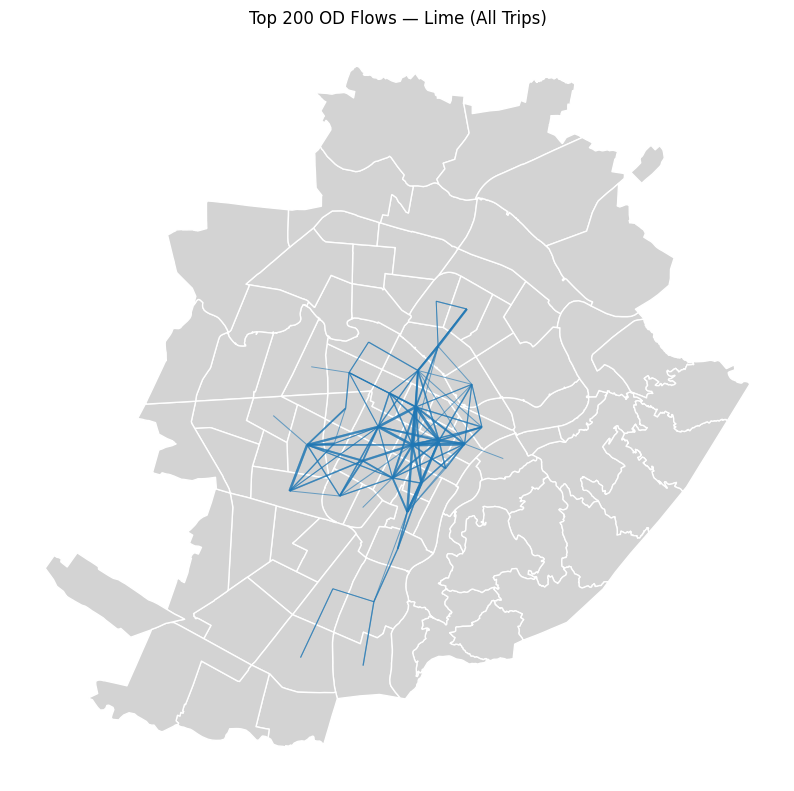

In [13]:
# ==============================
# STEP 7 — FLOW MAP (GLOBAL)
# ==============================

import matplotlib.pyplot as plt
from shapely.geometry import LineString

# ----------------------------------
# 1️⃣ Prepare zone centroids
# ----------------------------------

zones_centroids = zones.copy()
zones_centroids["centroid"] = zones_centroids.geometry.centroid
zones_centroids = zones_centroids.set_geometry("centroid")

zone_coords = zones_centroids[["ZONASTAT", "centroid"]].copy()
zone_coords["x"] = zone_coords.centroid.x
zone_coords["y"] = zone_coords.centroid.y

zone_coords = zone_coords.drop(columns="centroid")

# ----------------------------------
# 2️⃣ Select top flows
# ----------------------------------

top_flows = od_table.head(200).copy()

# Merge origin coords
top_flows = top_flows.merge(
    zone_coords,
    left_on="ORIGIN_ZONE",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"x": "x_origin", "y": "y_origin"})

top_flows = top_flows.drop(columns="ZONASTAT")

# Merge destination coords
top_flows = top_flows.merge(
    zone_coords,
    left_on="DESTINATION_ZONE",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"x": "x_dest", "y": "y_dest"})

top_flows = top_flows.drop(columns="ZONASTAT")

# ----------------------------------
# 3️⃣ Create line geometries
# ----------------------------------

top_flows["geometry"] = top_flows.apply(
    lambda row: LineString([
        (row["x_origin"], row["y_origin"]),
        (row["x_dest"], row["y_dest"])
    ]),
    axis=1
)

flow_gdf = gpd.GeoDataFrame(top_flows, geometry="geometry", crs="EPSG:4326")

# ----------------------------------
# 4️⃣ Plot
# ----------------------------------

fig, ax = plt.subplots(figsize=(10, 10))

zones.plot(ax=ax, color="lightgrey", edgecolor="white")

flow_gdf.plot(
    ax=ax,
    linewidth=flow_gdf["FLOW"] / flow_gdf["FLOW"].max() * 3,
    alpha=0.6
)

plt.title("Top 200 OD Flows — Lime (All Trips)")
plt.axis("off")
plt.show()


In [14]:
# ==============================
# STEP 7 — INTERACTIVE FLOW MAP (FOLIUM)
# ==============================

import folium
from shapely.geometry import LineString
import branca.colormap as cm

# ----------------------------------
# 1️⃣ Prepare zone centroids
# ----------------------------------

zones_centroids = zones.copy()
zones_centroids["centroid"] = zones_centroids.geometry.centroid
zones_centroids = zones_centroids.set_geometry("centroid")

zone_coords = zones_centroids[["ZONASTAT", "centroid"]].copy()
zone_coords["lat"] = zone_coords.centroid.y
zone_coords["lon"] = zone_coords.centroid.x
zone_coords = zone_coords.drop(columns="centroid")

# ----------------------------------
# 2️⃣ Select top flows
# ----------------------------------

top_flows = od_table.head(200).copy()

# Merge origin coords
top_flows = top_flows.merge(
    zone_coords,
    left_on="ORIGIN_ZONE",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"lat": "lat_origin", "lon": "lon_origin"})

top_flows = top_flows.drop(columns="ZONASTAT")

# Merge destination coords
top_flows = top_flows.merge(
    zone_coords,
    left_on="DESTINATION_ZONE",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"lat": "lat_dest", "lon": "lon_dest"})

top_flows = top_flows.drop(columns="ZONASTAT")

# ----------------------------------
# 3️⃣ Create base map (center Torino)
# ----------------------------------

center_lat = zones.geometry.centroid.y.mean()
center_lon = zones.geometry.centroid.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

# ----------------------------------
# 4️⃣ Color scale
# ----------------------------------

max_flow = top_flows["FLOW"].max()

colormap = cm.linear.YlOrRd_09.scale(0, max_flow)
colormap.caption = "OD Flow Intensity"
colormap.add_to(m)

# ----------------------------------
# 5️⃣ Add flow lines
# ----------------------------------

for _, row in top_flows.iterrows():
    
    flow_value = row["FLOW"]
    
    folium.PolyLine(
        locations=[
            (row["lat_origin"], row["lon_origin"]),
            (row["lat_dest"], row["lon_dest"])
        ],
        weight= (flow_value / max_flow) * 6,
        color= colormap(flow_value),
        opacity=0.7,
        tooltip=(
            f"Origin: {row['ORIGIN_ZONE']}<br>"
            f"Destination: {row['DESTINATION_ZONE']}<br>"
            f"Flow: {flow_value}"
        )
    ).add_to(m)

m


/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/248224469.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_centroids["centroid"] = zones_centroids.geometry.centroid
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/248224469.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_coords["lat"] = zone_coords.centroid.y
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/248224469.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_coords["lon"] = zone_coords.centroid.x
/var/folders/h0/khxnf7v151599zc19wcwyyfw0

In [19]:
m.save("Top 200 OD Flows — Lime (All Trips).html")

In [15]:
# ==============================
# STEP 8 — ORIGIN INTENSITY MAP
# ==============================

import folium
import branca.colormap as cm

# ----------------------------------
# 1️⃣ Compute total outbound trips per zone
# ----------------------------------

origin_counts = (
    lime_od
    .groupby("ORIGIN_ZONE")
    .size()
    .reset_index(name="TOTAL_ORIGIN_TRIPS")
)

# ----------------------------------
# 2️⃣ Merge with zones
# ----------------------------------

zones_intensity = zones.merge(
    origin_counts,
    left_on="ZONASTAT",
    right_on="ORIGIN_ZONE",
    how="left"
)

zones_intensity["TOTAL_ORIGIN_TRIPS"] = zones_intensity["TOTAL_ORIGIN_TRIPS"].fillna(0)

# ----------------------------------
# 3️⃣ Create base map
# ----------------------------------

center_lat = zones.geometry.centroid.y.mean()
center_lon = zones.geometry.centroid.x.mean()

m_choro = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles="cartodbpositron"
)

# ----------------------------------
# 4️⃣ Create color scale
# ----------------------------------

max_value = zones_intensity["TOTAL_ORIGIN_TRIPS"].max()

colormap = cm.linear.YlOrRd_09.scale(0, max_value)
colormap.caption = "Total Origin Trips"
colormap.add_to(m_choro)

# ----------------------------------
# 5️⃣ Add choropleth layer
# ----------------------------------

folium.GeoJson(
    zones_intensity,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["TOTAL_ORIGIN_TRIPS"]),
        "color": "white",
        "weight": 0.5,
        "fillOpacity": 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["ZONASTAT", "TOTAL_ORIGIN_TRIPS"],
        aliases=["Zone:", "Origin Trips:"]
    )
).add_to(m_choro)

m_choro


/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/187951511.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = zones.geometry.centroid.y.mean()
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/187951511.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = zones.geometry.centroid.x.mean()


In [20]:

m_choro.save("Origin Intensity Lime.html")

In [16]:
# ==============================
# STEP 8B — PERIOD CHOROPLETH MAPS (LIME)
# ==============================

import folium
import branca.colormap as cm

def create_choropleth_by_period(data, period_name):
    
    # ----------------------------------
    # 1️⃣ Filter period
    # ----------------------------------
    
    subset = data[data["TIME_PERIOD"] == period_name].copy()
    
    # ----------------------------------
    # 2️⃣ Compute origin counts
    # ----------------------------------
    
    origin_counts = (
        subset
        .groupby("ORIGIN_ZONE")
        .size()
        .reset_index(name="TOTAL_ORIGIN_TRIPS")
    )
    
    # ----------------------------------
    # 3️⃣ Merge with zoning
    # ----------------------------------
    
    zones_period = zones.merge(
        origin_counts,
        left_on="ZONASTAT",
        right_on="ORIGIN_ZONE",
        how="left"
    )
    
    zones_period["TOTAL_ORIGIN_TRIPS"] = zones_period["TOTAL_ORIGIN_TRIPS"].fillna(0)
    
    # ----------------------------------
    # 4️⃣ Create map
    # ----------------------------------
    
    center_lat = zones.geometry.centroid.y.mean()
    center_lon = zones.geometry.centroid.x.mean()
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles="cartodbpositron"
    )
    
    max_value = zones_period["TOTAL_ORIGIN_TRIPS"].max()
    
    colormap = cm.linear.YlOrRd_09.scale(0, max_value)
    colormap.caption = f"{period_name} — Origin Trips"
    colormap.add_to(m)
    
    folium.GeoJson(
        zones_period,
        style_function=lambda feature: {
            "fillColor": colormap(feature["properties"]["TOTAL_ORIGIN_TRIPS"]),
            "color": "white",
            "weight": 0.5,
            "fillOpacity": 0.7
        },
        tooltip=folium.GeoJsonTooltip(
            fields=["ZONASTAT", "TOTAL_ORIGIN_TRIPS"],
            aliases=["Zone:", "Origin Trips:"]
        )
    ).add_to(m)
    
    return m


# Generate maps
map_morning = create_choropleth_by_period(lime_od, "Morning Peak")
map_evening = create_choropleth_by_period(lime_od, "Evening Peak")
map_offpeak = create_choropleth_by_period(lime_od, "Off Peak")

map_morning


/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/1372176745.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = zones.geometry.centroid.y.mean()
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/1372176745.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = zones.geometry.centroid.x.mean()
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_23143/1372176745.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = zones.geometry.centroid.y.mean()
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipy

In [21]:

map_morning.save("(Morning Peak)Spatial Distribution of Outgoing flows_Lime.html")

In [17]:
map_evening


In [22]:
map_evening.save("(Evening Peak)Spatial Distribution of Outgoing flows_Lime.html")

In [ ]:
map_offpeak


In [23]:
map_offpeak.save("(Off Peak)Spatial Distribution of Outgoing flows_Lime.html")